In [39]:
import numpy as np
import matplotlib.pyplot as plt
from diffractio import um, mm, np
from diffractio.scalar_sources_X import Scalar_source_X
from diffractio.scalar_masks_X import Scalar_mask_X
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY
from numba import njit, prange
%matplotlib ipympl

Functions for diffractio rayleigh sommerfeld FFT method

In [40]:
def diffractio_rs_aperture_1D(x0, 
                           z_prop,
                           aperture_width, 
                           wavelength,
                           draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_X(x0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_X(x0, wavelength)
    t0.slit(x0=0, size=aperture_width*um)

    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw()
        t0.draw()

    return u2

def diffractio_rs_aperture_2D(x0, 
                              y0,
                              z_prop,
                              aperture_width, 
                              wavelength,
                              draw_inputs=False):

    # Make scalar source
    u0 = Scalar_source_XY(x0, y0, wavelength)
    u0.plane_wave(z0=0)

    # Make scalar diffraction mask
    t0=Scalar_mask_XY(x0, y0, wavelength)
    t0.slit(x0=0, size=aperture_width*um, angle=0)

    u1=t0*u0
    z = z_prop
    u2 = u1.RS(z=z, new_field=True)

    if draw_inputs:
        u0.draw(kind='intensity')
        t0.draw(kind='intensity')

    return u2

Main monte carlo function: There are two options, with plane wave approximation, whereby each ray is assumed to be a plane wave, and thus can affect every pixel on the detector, or without plane wave approxitation, where the each ray affects only one pixel on the detector. See the notebook "PlaneWaveVectorDisplay" to see what vectors must be calculated to shift the wavefront correctly onto the detector. To include phase shifts from a sample, the sample phase shifts array is just the potential times the interaction constant from abtem. Otherwise, if it is an aperture, this is just an array of 1+0j complex numbers the same shape as the aperture as no phase shift is applied by the aperture. 

In [41]:
@njit(parallel=True)
def monte_carlo_diffraction(num_rays, 
                            final_image,
                            sample_yx_indices,
                            sample_yx_coords,
                            det_yx_indices,
                            det_zyx_coords,
                            sample_phase_shifts,
                            z_prop,
                            wavelength,
                            planewaveapprox):
    
    len_sample_indices = sample_yx_indices.shape[0]
    len_det_indices = det_yx_indices.shape[0]
    
    for _ in prange(num_rays):

        # Get random pixel samples of the sample (or aperture) and the detector
        random_sample_coord_idx = np.random.randint(len_sample_indices)
        random_detector_coord_idx = np.random.randint(len_det_indices)
        
        sample_phase_shift = sample_phase_shifts[random_sample_coord_idx]
        random_sample_coord_yx = sample_yx_coords[random_sample_coord_idx]
        
        random_detector_coord_zyx = det_zyx_coords[random_detector_coord_idx]

        # Calculate distance between pixel chosen in sample and detector
        x_dist = random_sample_coord_yx[1] - random_detector_coord_zyx[2]
        y_dist = random_sample_coord_yx[0] - random_detector_coord_zyx[1]
        distance = np.sqrt(x_dist ** 2 + y_dist ** 2 + z_prop ** 2)

        ray_dir_cosine = z_prop / distance

        # See Chapter 2 of Marco Mout thesis for reasoning behind wi_ws: I think it comes from 
        # the Rayleigh Sommerfeld Diffraction Integral obliquity factor
        wi_ws = np.sqrt(1 / ray_dir_cosine) * ray_dir_cosine 

        if planewaveapprox:
            
            # Get ray vector and make it a unit vector
            ray_v = np.array([z_prop, y_dist, x_dist])
            ray_unit_v = ray_v/np.linalg.norm(ray_v)
            
            # Get vector pointing from detector pixel coordinates to where the ray has hit. 
            v = random_detector_coord_zyx - det_zyx_coords
            
            # Dot product v with the direction vector of the ray, to find the component of the vector v in the direction of the ray
            # This tells us the distance from the detector pixel to the tilted plane normal to the direction of the ray, which tells us the path length
            # difference we must apply to calculate the phase of the plane wave at each pixel on the detector. 
            signed_length_wavefront_to_px = np.dot(v, ray_unit_v)
            
            # Find phase of wavefront at each pixel in the detector, and also the phase shift of the sample
            distance_phases = np.exp(1j * (distance + signed_length_wavefront_to_px) * ((2 * np.pi) / wavelength))
            sample_phase = np.exp(1j * (sample_phase_shift))
            
            # Add complex wavefront to each pixel in the image
            final_image +=  wi_ws * distance_phases * sample_phase
        else:
            
            # Find phase of wavefront at randomly selected detector pixel, and also the phase shift of the sample
            distance_phase = np.exp(1j * distance * ((2 * np.pi) / wavelength))
            sample_phase = np.exp(1j * (sample_phase_shift))
            
            # Add complex wavefront to each pixel in the image - the extra amplitude factors in this function at the end are to try and approximate the RS
            # diffraction integral for a single ray, but mainly they are here because I don't understand Marco Mouts intensity calculation. By including these factor
            # we correctly estimate the shape of the diffraction pattern when I look at it in a plane near the aperture. 
            final_image[random_detector_coord_idx] +=  wi_ws * distance_phase * sample_phase * (1 / distance) * (1 / 1j * wavelength)

    return final_image

1D Aperture test - try and calculate the diffraction pattern some distance z after the aperture. 

In [42]:
aperture_diameter = 200 * um
detector_width_x = 1000 * um
detector_width_y = 0 * um

num_px_x = 1024
num_px_y = 1
final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()

detector_px_width_x = detector_width_x / num_px_x
detector_px_width_y = detector_width_y / num_px_y

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices[np.sqrt(det_yx_coords[:, 0]**2 + det_yx_coords[:, 1]**2) < aperture_diameter/2]
sample_yx_coords = det_yx_coords[np.sqrt(det_yx_coords[:, 0]**2 + det_yx_coords[:, 1]**2) < aperture_diameter/2]
aperture_phase_shifts = np.zeros_like(final_image, dtype = np.complex128)

z_prop = 5 * mm
wavelength = 0.638 * um

final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
print('Fresnel Number = ', aperture_diameter/(wavelength * (z_prop**2)))

Fresnel Number =  1.2539184952978056e-05


Show initial field, aperture, and calculate the diffracted field some distance z after the aperture using the Hankel Transform in diffractio. 

Good result: factor 3.27


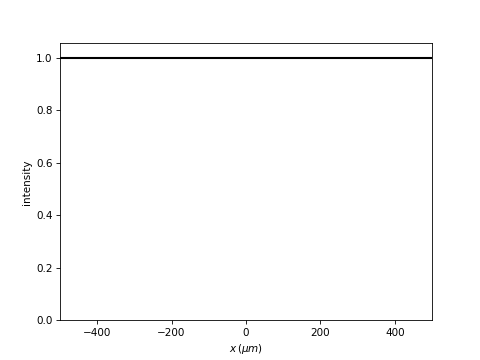

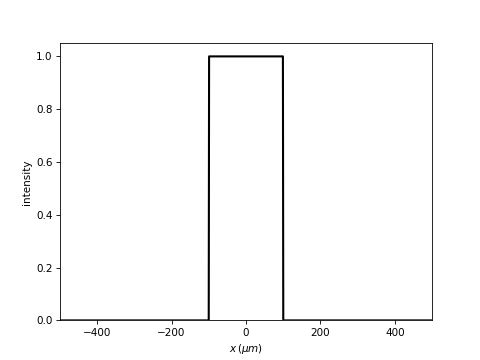

In [43]:
u2 = diffractio_rs_aperture_1D(x0=det_yx_coords[:, 1], 
                            z_prop=z_prop, 
                            aperture_width=aperture_diameter, 
                            wavelength=wavelength, 
                            draw_inputs=True)

Explanation of how monte carlo method works: The Huygens Fresnel Principle states that every point on a wavefront is itself the source of spherical wavelets (See image below). The Rayleigh Sommerfeld diffraction integral is a mathematical description of this principle. We can exploit the Huygens Fresnel principle in regions where geometrical optics breaks down (such as at an aperture or in a thin sample) to continue to propagate rays which also carry information about an aperture or sample. By sampling random directions on each spherical wavefront at a "diffracting surface" and propagating rays forward we can perform a "monte carlo integration" solution to the rayleigh sommerfeld diffraction integral, which allows us to circumvent the use of Fourier methods to solve this diffraction integral, enabling us to more easily integrate wavefront propagation in the context of real microscope components that span large distances. The drawback of this method is that many rays are required, but with modern processing power we may be able to mitigate this.

Below: Image of Huygens Fresnel Principle.

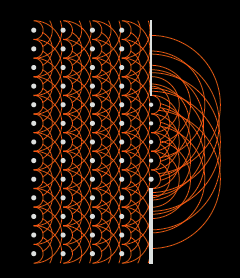


Solve RS diffraction integral with monte carlo method.

In [44]:
num_rays=int(1e9)
planewaveapprox=False

final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image = monte_carlo_diffraction(num_rays, 
                                      final_image,
                                      sample_yx_indices,
                                      sample_yx_coords,
                                      det_yx_indices,
                                      det_zyx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox)

Solve RS diffraction integral with monte carlo method with plane wave approximation.

In [45]:
planewaveapprox=True
num_rays=int(1e6)
final_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image_pw = monte_carlo_diffraction(num_rays, 
                                      final_image_pw,
                                      sample_yx_indices,
                                      sample_yx_coords,
                                      det_yx_indices,
                                      det_zyx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox)

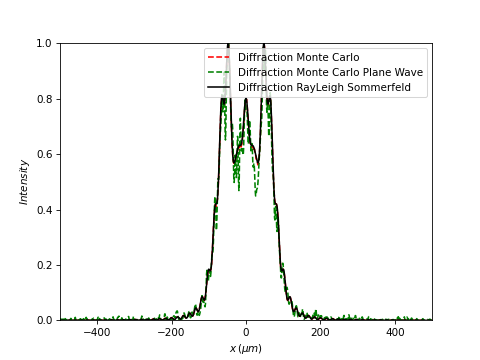

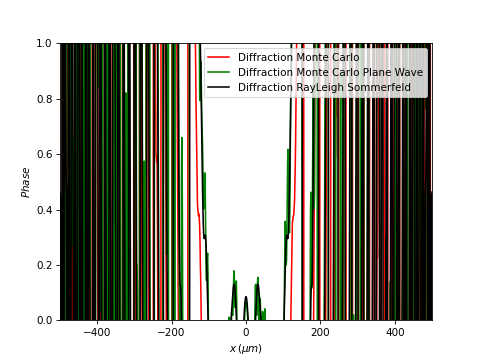

In [46]:

fig, ax = plt.subplots()

ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Intensity$')
ax.set_xlim(left=det_yx_coords[0, 1], right=det_yx_coords[-1, 1])
ax.set_ylim(bottom=0)
ax.plot(det_yx_coords[:, 1], np.abs(final_image)**2/np.max(np.abs(final_image)**2), '--r', label='Diffraction Monte Carlo')
ax.plot(det_yx_coords[:, 1], np.abs(final_image_pw)**2/np.max(np.abs(final_image_pw)**2), '--g', label='Diffraction Monte Carlo Plane Wave')
ax.plot(det_yx_coords[:, 1], np.abs(u2.u)**2/np.max(np.abs(u2.u)**2), '-k', label='Diffraction RayLeigh Sommerfeld')
plt.legend()

fig, ax = plt.subplots()
ax.set_xlabel('$x\,(\mu m)$')
ax.set_ylabel('$Phase$')
ax.set_xlim(left=det_yx_coords[0, 1], right=det_yx_coords[-1, 1])
ax.set_ylim(bottom=0)
ax.plot(det_yx_coords[:, 1], np.angle(final_image), 'r', label='Diffraction Monte Carlo')
ax.plot(det_yx_coords[:, 1], np.angle(final_image_pw), 'g', label='Diffraction Monte Carlo Plane Wave')
ax.plot(det_yx_coords[:, 1], np.angle(u2.u), '-k', label='Diffraction RayLeigh Sommerfeld')

plt.legend()


Not bad, seems to have much of the features from diffractio, now can perform same test, but in a 2D case. 

In [47]:
aperture_diameter = 200 * um
detector_width_x = 1000 * um
detector_width_y = 1000 * um

num_px_x = 128
num_px_y = 128
final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()

detector_px_width_x = detector_width_x / num_px_x
detector_px_width_y = detector_width_y / num_px_y

y_indices, x_indices = np.meshgrid(np.arange(num_px_y), np.arange(num_px_x), indexing='ij')

# Combine the coordinates into a single array of (y, x) pairs
det_yx_indices = np.vstack([y_indices.ravel(), x_indices.ravel()]).T
num_pixels = int(num_px_x*num_px_y)

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices[np.abs(det_yx_coords[:, 1]) < aperture_diameter/2]
sample_yx_coords = det_yx_coords[np.abs(det_yx_coords[:, 1]) < aperture_diameter/2]
aperture_phase_shifts = np.zeros_like(final_image, dtype = np.complex128)

z_prop = 5 * mm
wavelength = 0.638 * um

print('Fresnel Number = ', aperture_diameter/(wavelength * (z_prop**2)))

Fresnel Number =  1.2539184952978056e-05


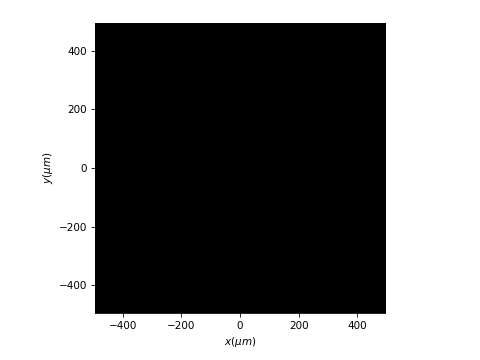

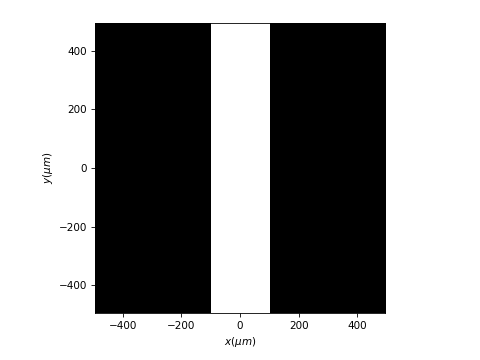

In [48]:
u2 = diffractio_rs_aperture_2D(x0=det_zyx_coords[:num_px_x, 2], 
                               y0=det_zyx_coords[:num_px_y, 2],
                               z_prop=z_prop, 
                               aperture_width=aperture_diameter, 
                               wavelength=wavelength, 
                               draw_inputs=True)

/tmp/ipykernel_1248860/215991598.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


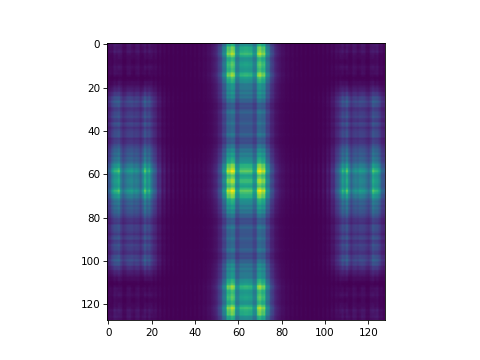

In [49]:
fig, ax = plt.subplots()
ax.imshow(np.abs(u2.u) ** 2, label='Diffraction RayLeigh Sommerfeld')

In [50]:
num_rays=int(1e9)
planewaveapprox=False

final_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image = monte_carlo_diffraction(num_rays, 
                                      final_image,
                                      sample_yx_indices,
                                      sample_yx_coords,
                                      det_yx_indices,
                                      det_zyx_coords,
                                      aperture_phase_shifts,
                                      z_prop,
                                      wavelength,
                                      planewaveapprox)

final_image = final_image.reshape(num_px_y, num_px_x)

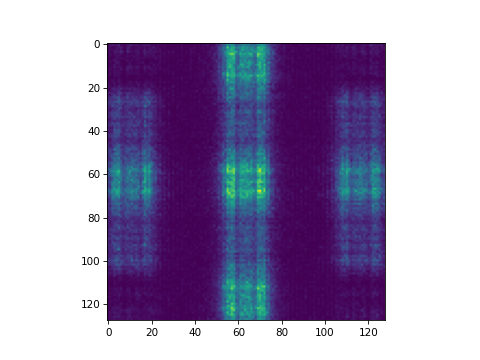

In [51]:
fig, ax = plt.subplots()
ax.imshow((np.abs(final_image) ** 2)/np.max(np.abs(final_image) ** 2), label='Diffraction Monte Carlo')

For some reason, plane wave approximation in 2D is giving me a lot of trouble. 

In [52]:
num_rays=int(1e5)
planewaveapprox=True

final_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
final_image_pw = monte_carlo_diffraction(num_rays, 
                                         final_image_pw,
                                         sample_yx_indices,
                                         sample_yx_coords,
                                         det_yx_indices,
                                         det_zyx_coords,
                                         aperture_phase_shifts,
                                         z_prop,
                                         wavelength,
                                         planewaveapprox)

final_image_pw = final_image_pw.reshape(num_px_y, num_px_x)

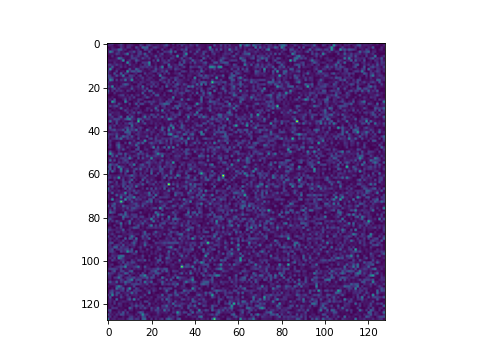

In [53]:
fig, ax = plt.subplots()

ax.imshow((np.abs(final_image_pw) ** 2)/np.max(np.abs(final_image_pw) ** 2), label='Diffraction Monte Carlo Plane Wave')

Mixed results: 1D case seems good, and 2D case works without plane wave approximation, but with lots of rays. Plane wave approximation fails completely. Now we can text with atoms. Lets try a slice through 1 atom first. 

[                                        ] | 0% Completed | 1.09 ms

[########################################] | 100% Completed | 102.11 ms


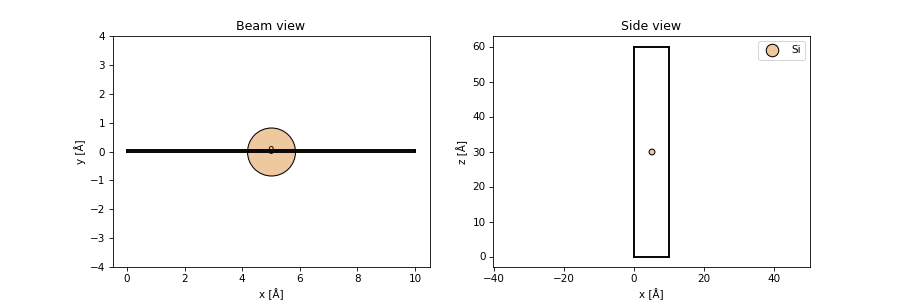

In [76]:
import ase
import numpy as np
import abtem
import matplotlib.pyplot as plt
from typing import Tuple, NamedTuple

%config InlineBackend.rc = {"figure.dpi": 72, "figure.figsize": (6.0, 4.0)}

# atoms = ase.Atoms(
#     "Si2", positions=[(1.0, 2.0, 1.0), (3.0, 2.0, 1.0)], cell=[4, 4, 2]
# )

x1 = 1.0
atom_spacing = 3.0
x2 = x1 + atom_spacing
x_centre = 5.0
x0 = x_centre - (x1) - atom_spacing/2
z_start = 60
z_atoms = 30
z_prop = z_atoms

atoms = ase.Atoms(
    "Si1", positions=[(x_centre, 0, z_atoms)], cell=[x_centre*2, 0.05, z_start]
)

phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.05, projection="infinite", slice_thickness=30)

potential_array = potential.build().project().compute()




[########################################] | 100% Completed | 102.80 ms


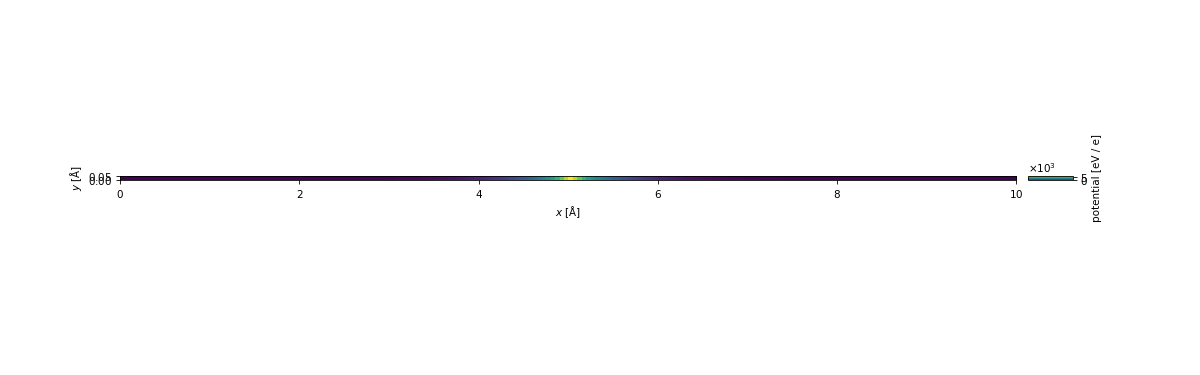

In [55]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [56]:
PHI_0 = 100e3
plane_wave_abtem = abtem.PlaneWave(energy=PHI_0, extent=(10, 0.05), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 102.56 ms


In [57]:
from abtem.core.energy import energy2sigma, energy2wavelength



sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices.copy()
sample_yx_coords = det_yx_coords.copy()

sample_phase_shift = (potential_array.array * sigma).ravel()


In [58]:
planewaveapprox=False
num_rays=int(1e7)
atom_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image = monte_carlo_diffraction(num_rays, 
                                    atom_image,
                                    sample_yx_indices,
                                    sample_yx_coords,
                                    det_yx_indices,
                                    det_zyx_coords,
                                    sample_phase_shift,
                                    z_prop,
                                    wavelength,
                                    planewaveapprox)


In [59]:
planewaveapprox=True
num_rays=int(1e7)
atom_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image_pw = monte_carlo_diffraction(num_rays, 
                                    atom_image_pw,
                                    sample_yx_indices,
                                    sample_yx_coords,
                                    det_yx_indices,
                                    det_zyx_coords,
                                    sample_phase_shift,
                                    z_prop,
                                    wavelength,
                                    planewaveapprox)

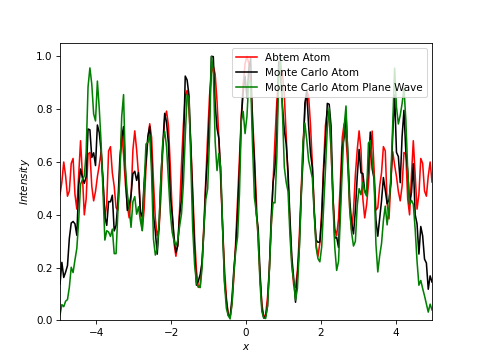

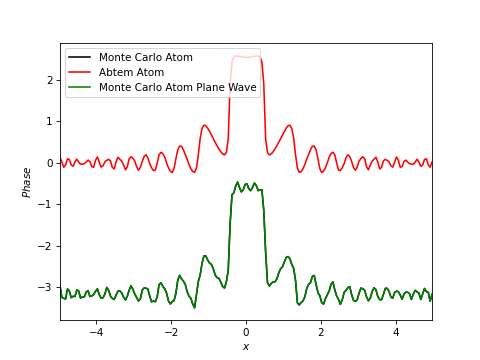

In [60]:
fig, ax = plt.subplots()
ax.plot(det_yx_coords[:, 1], np.abs(complex_image.array)**2/np.max(np.abs(complex_image.array)**2), '-r', label='Abtem Atom')
ax.plot(det_yx_coords[:, 1], np.abs(atom_image)**2/np.max(np.abs(atom_image)**2), '-k', label='Monte Carlo Atom')
ax.plot(det_yx_coords[:, 1], np.abs(atom_image_pw)**2/np.max(np.abs(atom_image_pw)**2), '-g', label='Monte Carlo Atom Plane Wave')
ax.set_xlabel('$x$')
ax.set_ylabel('$Intensity$')
ax.set_xlim(left=det_yx_coords[0, 1], right=det_yx_coords[-1, 1])
ax.set_ylim(bottom=0)
plt.legend()

monte_carlo_phase = np.angle(atom_image_pw)
monte_carlo_phase = np.unwrap(monte_carlo_phase)

monte_carlo_phase_pw = np.angle(atom_image_pw)
monte_carlo_phase_pw = np.unwrap(monte_carlo_phase)


fig, ax = plt.subplots()
ax.plot(det_yx_coords[:, 1], monte_carlo_phase, '-k', label='Monte Carlo Atom')
ax.plot(det_yx_coords[:, 1], np.angle(complex_image.array), '-r', label='Abtem Atom')
ax.plot(det_yx_coords[:, 1], monte_carlo_phase_pw, '-g', label='Monte Carlo Atom Plane Wave')
ax.set_xlabel('$x$')
ax.set_ylabel('$Phase$')
ax.set_xlim(left=det_yx_coords[0, 1], right=det_yx_coords[-1, 1])
# ax.set_ylim(bottom=0)
plt.legend()

Result for single atom seems to work for plane wave approximation, and without it. Now try a single atom in 2D. 

[########################################] | 100% Completed | 102.28 ms


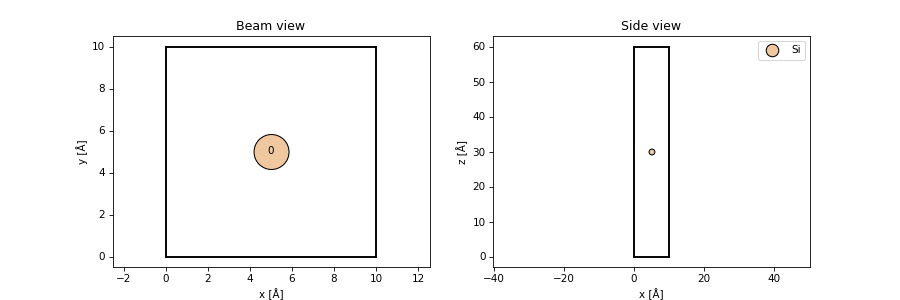

In [61]:
atoms = ase.Atoms(
    "Si1", positions=[(x_centre, x_centre, z_atoms)], cell=[x_centre*2, x_centre*2, z_start]
)

phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.1, projection="infinite", slice_thickness=30)

potential_array = potential.build().project().compute()

[########################################] | 100% Completed | 102.58 ms


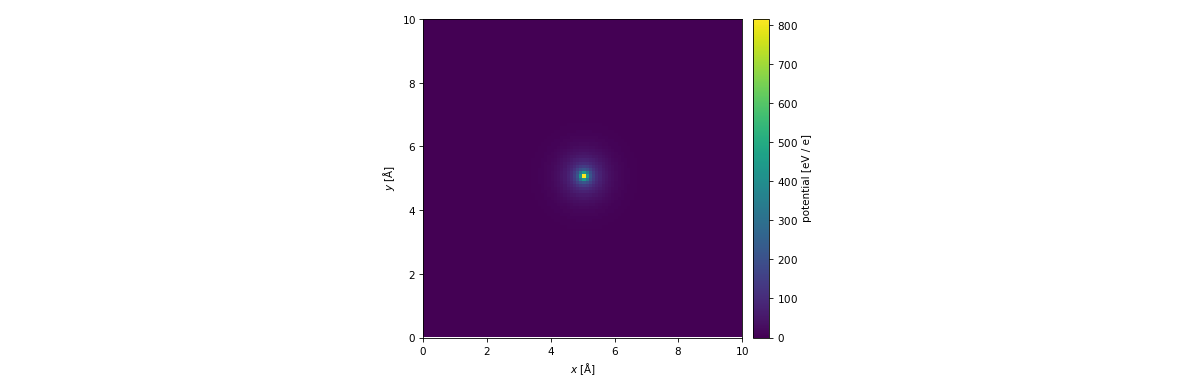

In [62]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [63]:
plane_wave_abtem = abtem.PlaneWave(energy=PHI_0, extent=(10, 10), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 102.17 ms


In [64]:
from abtem.core.energy import energy2sigma, energy2wavelength

sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices.copy()
sample_yx_coords = det_yx_coords.copy()

sample_phase_shifts = (potential_array.array * sigma).ravel()

In [65]:
planewaveapprox=False
num_rays=int(1e10)
atom_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image = monte_carlo_diffraction(num_rays, 
                                     atom_image,
                                     sample_yx_indices,
                                     sample_yx_coords,
                                     det_yx_indices,
                                     det_zyx_coords,
                                     sample_phase_shifts,
                                     z_prop,
                                     wavelength,
                                     planewaveapprox)

atom_image = atom_image.reshape(num_px_y, num_px_x)

In [66]:
planewaveapprox=True
num_rays=int(1e5)
atom_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image_pw = monte_carlo_diffraction(num_rays, 
                                        atom_image_pw,
                                        sample_yx_indices,
                                        sample_yx_coords,
                                        det_yx_indices,
                                        det_zyx_coords,
                                        sample_phase_shifts,
                                        z_prop,
                                        wavelength,
                                        planewaveapprox)
atom_image_pw = atom_image_pw.reshape(num_px_y, num_px_x)

Text(0.5, 1.0, 'Abtem')

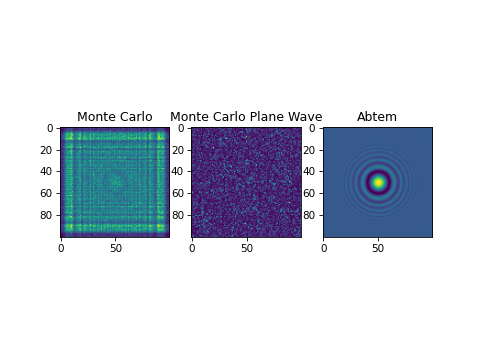

In [67]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(np.abs(atom_image)**2)
ax[0].set_title('Monte Carlo')
ax[1].imshow(np.abs(atom_image_pw)**2)
ax[1].set_title('Monte Carlo Plane Wave')
ax[2].imshow(np.abs(complex_image.array)**2)
ax[2].set_title('Abtem')

Text(0.5, 1.0, 'Abtem')

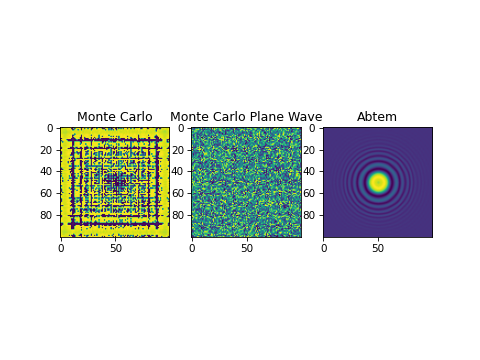

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(np.angle(atom_image))
ax[0].set_title('Monte Carlo')
ax[1].imshow(np.angle(atom_image_pw))
ax[1].set_title('Monte Carlo Plane Wave')
ax[2].imshow(np.angle(complex_image.array))
ax[2].set_title('Abtem')



Not a great result, The big difference could be because of some tampering abtem does with an aperture to cut off artefacts in fourier space. Plane wave approximation again fails completely in the 2D case. Results could be different also because abtem uses fresnel propagation, whereas we don't but I'm not convinced that explains such a big difference in the 2D case. 

Let's try with more atoms also in one slice. 

[                                        ] | 0% Completed | 1.50 ms

[########################################] | 100% Completed | 107.01 ms


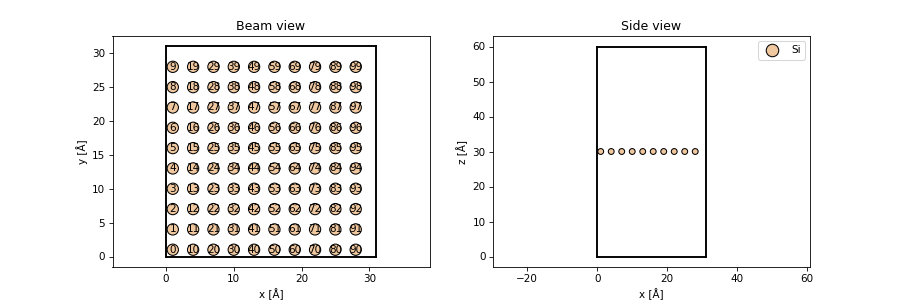

In [69]:
num_atoms_x = 10 
num_atoms_y = 10
atom_spacing = 3.0
x_start = 1.0
y_start = 1.0

# Create an empty Atoms object
atoms = ase.Atoms('Si0', cell=[x_start + num_atoms_x* atom_spacing, y_start + num_atoms_y* atom_spacing, z_start])

# Adding atoms in a row
for i in range(num_atoms_x):
    for j in range(num_atoms_y):
        x_position = x_start + i * atom_spacing
        y_position = y_start + j * atom_spacing
        atoms += ase.Atoms('Si1', positions=[(x_position, y_position, z_atoms)])


# Configure potential
phi_0 = 100e3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True)

potential = abtem.Potential(atoms, sampling=0.4, projection="infinite", slice_thickness=30)
potential_array = potential.build().project().compute()


[########################################] | 100% Completed | 102.31 ms


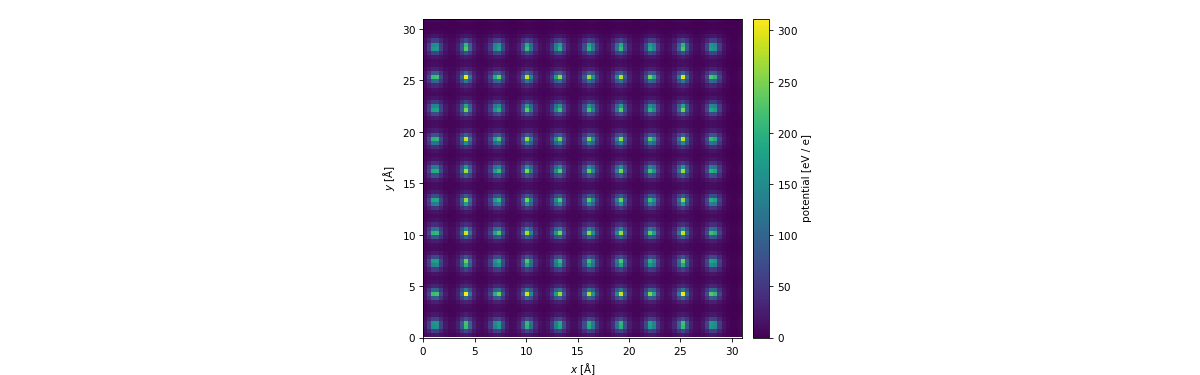

In [70]:
visualization = potential.show(
    project=True,
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    cbar=True,
)

In [71]:

plane_wave_abtem = abtem.PlaneWave(energy=PHI_0, extent=(10, 10), sampling=0.05)
exit_wave = plane_wave_abtem.multislice(potential)
exit_wave.compute()
intensity = exit_wave.intensity().compute()
complex_image = exit_wave.complex_images().compute()

[########################################] | 100% Completed | 101.89 ms


In [72]:
from abtem.core.energy import energy2sigma, energy2wavelength

sigma = energy2sigma(PHI_0)
wavelength = energy2wavelength(PHI_0)

detector_px_width_x, detector_px_width_y = potential.sampling
detector_width_x, detector_width_y = potential.extent
num_px_x, num_px_y = potential.gpts

num_pixels = int(num_px_x*num_px_y)
det_yx_indices = np.indices((num_px_y, num_px_x)).reshape(2, num_pixels).T

det_yx_coords = np.zeros(det_yx_indices.shape, dtype = np.float64)
det_yx_coords[:, 0] = det_yx_indices[:, 0] * detector_px_width_y - detector_width_y / 2  + detector_px_width_y / 2
det_yx_coords[:, 1] = det_yx_indices[:, 1] * detector_px_width_x - detector_width_x / 2  + detector_px_width_x / 2 
det_zyx_coords = np.concatenate((np.zeros((num_pixels, 1)), det_yx_coords), axis=1)

sample_yx_indices = det_yx_indices.copy()
sample_yx_coords = det_yx_coords.copy()

sample_phase_shifts = (potential_array.array * sigma).ravel()

In [73]:
planewaveapprox=False
num_rays=int(1e9)
atom_image = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image = monte_carlo_diffraction(num_rays, 
                                     atom_image,
                                     sample_yx_indices,
                                     sample_yx_coords,
                                     det_yx_indices,
                                     det_zyx_coords,
                                     sample_phase_shifts,
                                     z,
                                     wavelength,
                                     planewaveapprox)

atom_image = atom_image.reshape(num_px_y, num_px_x)


In [74]:
planewaveapprox=True
num_rays=int(1e5)
atom_image_pw = np.zeros([num_px_y, num_px_x], dtype = np.complex128).ravel()
atom_image_pw = monte_carlo_diffraction(num_rays, 
                                        atom_image_pw,
                                        sample_yx_indices,
                                        sample_yx_coords,
                                        det_yx_indices,
                                        det_zyx_coords,
                                        sample_phase_shifts,
                                        z,
                                        wavelength,
                                        planewaveapprox)
atom_image_pw = atom_image_pw.reshape(num_px_y, num_px_x)

Text(0.5, 1.0, 'Abtem')

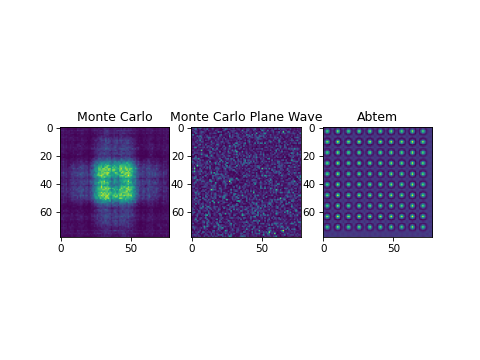

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=3)
ax[0].imshow(np.abs(atom_image)**2)
ax[0].set_title('Monte Carlo')
ax[1].imshow(np.abs(atom_image_pw)**2)
ax[1].set_title('Monte Carlo Plane Wave')
ax[2].imshow(np.abs(complex_image.array)**2)
ax[2].set_title('Abtem')

Another odd result. Not sure where to go from here. The square patterns in the monte carlo without plane wave are interesting. 